In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.simplefilter("ignore")
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')

In [4]:
def significant_pose_detection(arr, th):
    n = len(arr)
    i = 0
    for itemm in arr:
        if np.sum(itemm[0] + itemm[1]) != 0:
            i = i + 1

    sig_det = (i / n)
    if sig_det >= th:
        return 1

    return 0

def process_image(input_image_path, output_image_path):
    # Open the image file
    image = cv2.imread(input_image_path)

    # Process the image here...
    results = model.predict(image)[0]
    th = 0.3
    Q = []
    det = 0
    concat_df = pd.DataFrame()

    for result in results:
        landmarks = []
        kpts = result.keypoints
        nk = kpts.shape[1]

        for i in range(nk):
            keypoint = kpts.xy[0, i]
            x, y = int(keypoint[0].item()), int(keypoint[1].item())
            landmarks.append([x, y])

        detections = significant_pose_detection(landmarks, th)
        if detections == 1:
            det = det + 1
            for j in range(len(landmarks)):
                x = landmarks[j][0]
                y = landmarks[j][1]
                # cv2.circle(image, (x, y), 3, (0, 0, 255), -1)
                ttext = "("+str(x)+","+str(y)+")"
                # cv2.putText(image, ttext, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

            df = pd.DataFrame(landmarks, columns=['x' + str(det), 'y' + str(det)], dtype=float)
            concat_df = pd.concat([concat_df, df], axis=1)

            # cv2.line(image, landmarks[11], landmarks[12], (0, 255, 0), 2)
            a = (landmarks[11][0] + landmarks[12][0]) // 2
            b = (landmarks[11][1] + landmarks[12][1]) // 2
            Q.append([a, b])

    m = list(map(lambda l: [v for v in l if v != 0], Q))
    nQ = [ele for ele in m if ele != []]

    k = len(nQ)

    i = 0
    while i < (k - 1):
        # cv2.line(image, nQ[i], nQ[i + 1], (255, 0, 0), 2)
        i = i + 1

    i = 0
    while i < k:
        # cv2.circle(image, nQ[i], 5, (0, 255, 255), -1)
        # cv2.circle(image, nQ[i], 7, (0, 0, 255), 2)
        i = i + 1

    concat_df.to_csv('detected_pose.csv')
    df_nQ = pd.DataFrame(nQ, columns=['x', 'y'], dtype=int)
    df_nQ.to_csv('nQ_centroids.csv')

    # Perform linear regression and outlier detection
    url = 'nQ_centroids.csv'
    data = pd.read_csv(url)
    x = data['x'].values
    y = data['y'].values

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    y_pred = intercept + slope * x
    residuals = y - y_pred

    residuals_std = np.std(residuals)

    ci_lower = y_pred - 1.440 * residuals_std
    ci_upper = y_pred + 1.440 * residuals_std

    outliers = np.where((y < ci_lower) | (y > ci_upper))

    print("Outliers: ", outliers)

    # persons = concat_df.values.reshape(-1, 8, 2)
    persons = concat_df.values

    for i in outliers[0]:
        x_coords = concat_df['x' + str(i + 1)].dropna().values
        y_coords = concat_df['y' + str(i + 1)].dropna().values
        person = np.column_stack((x_coords, y_coords))
        person = person[~np.all(person == [0, 0], axis=1)]
        x_min, y_min = np.min(person, axis=0)
        x_max, y_max = np.max(person, axis=0)
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 0, 255), 2)

    # Save the processed image to the output path
    cv2.imwrite(output_image_path, image)
    cv2_imshow(image)


0: 448x640 12 persons, 390.5ms
Speed: 20.5ms preprocess, 390.5ms inference, 36.7ms postprocess per image at shape (1, 3, 448, 640)
Outliers:  (array([0, 7]),)


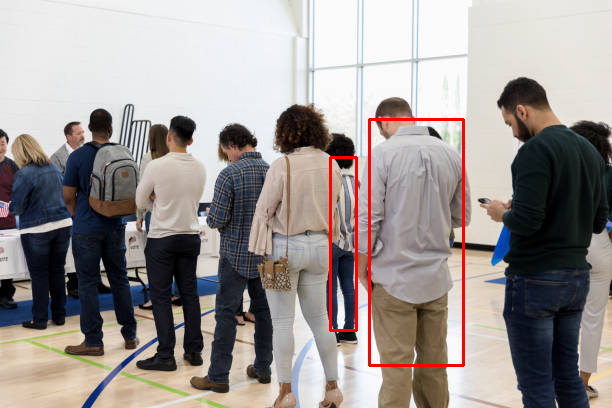

In [5]:
process_image('Q3_pose.png', 'output_image.jpg')


0: 448x640 8 persons, 181.9ms
Speed: 3.6ms preprocess, 181.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Outliers:  (array([0]),)


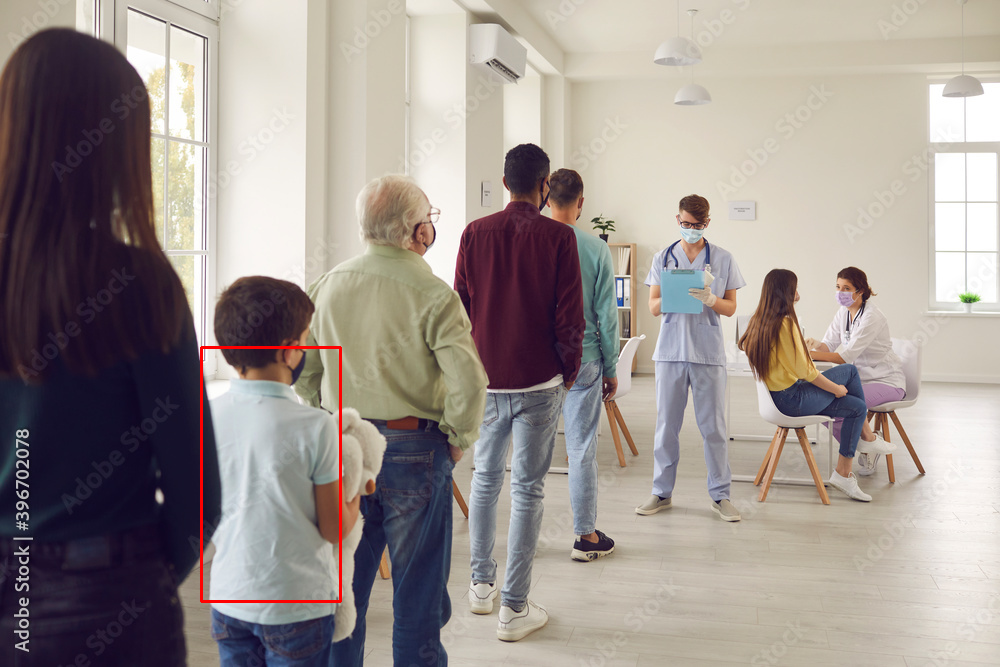

In [6]:
process_image('Q3_pose5.jpg', 'output_image.jpg')


0: 544x640 8 persons, 479.3ms
Speed: 15.4ms preprocess, 479.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)
Outliers:  (array([0]),)


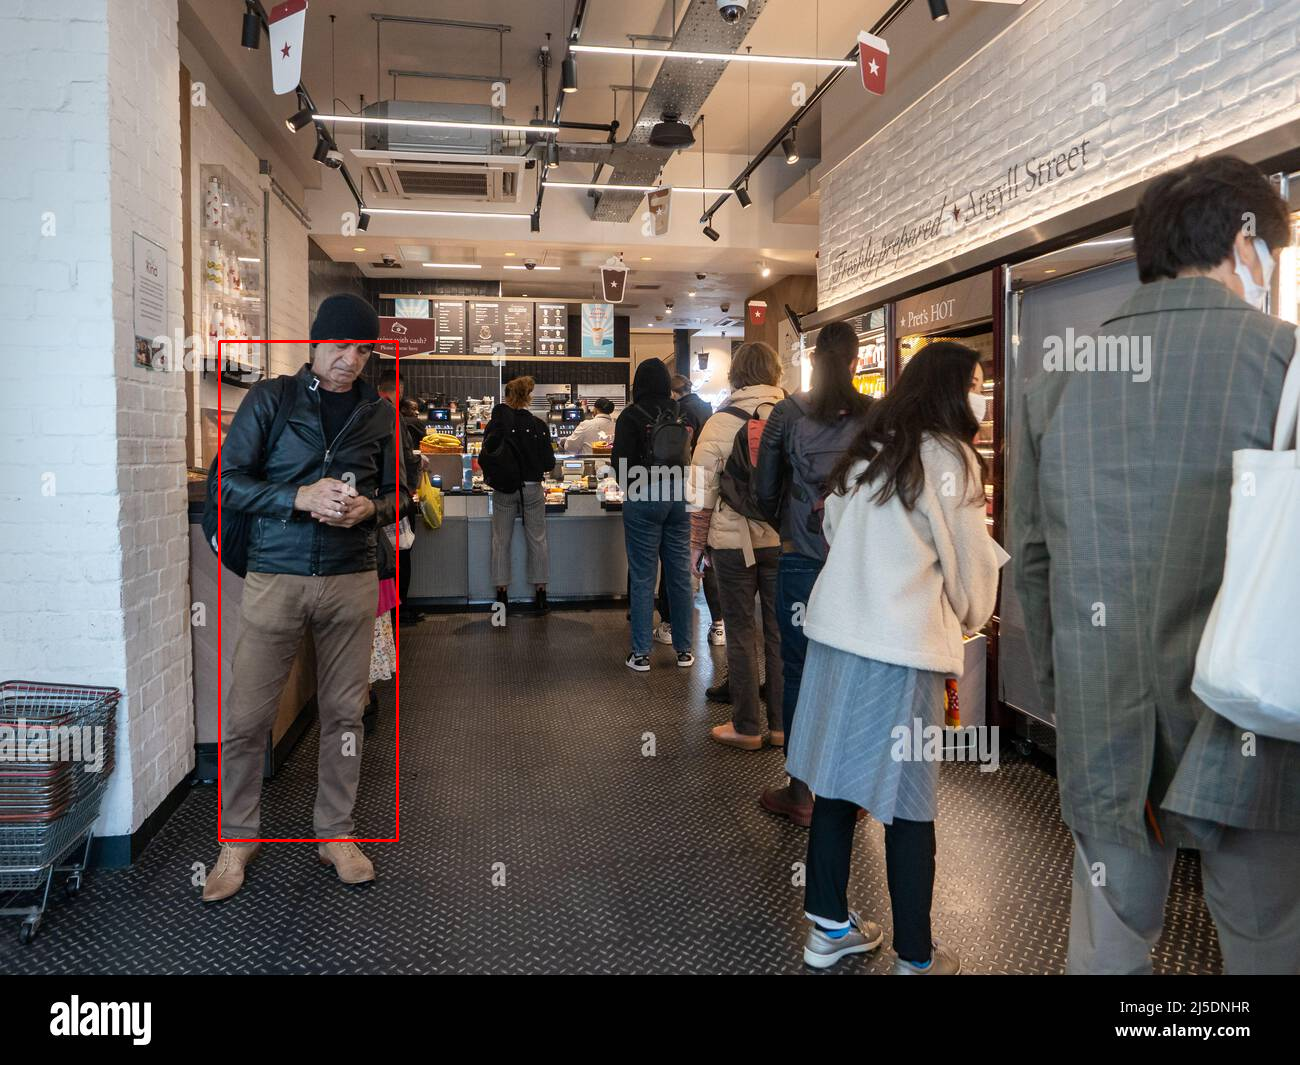

In [7]:
process_image('Q3_pose6.jpg', 'output_image.jpg')


0: 480x640 10 persons, 241.4ms
Speed: 5.5ms preprocess, 241.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Outliers:  (array([7]),)


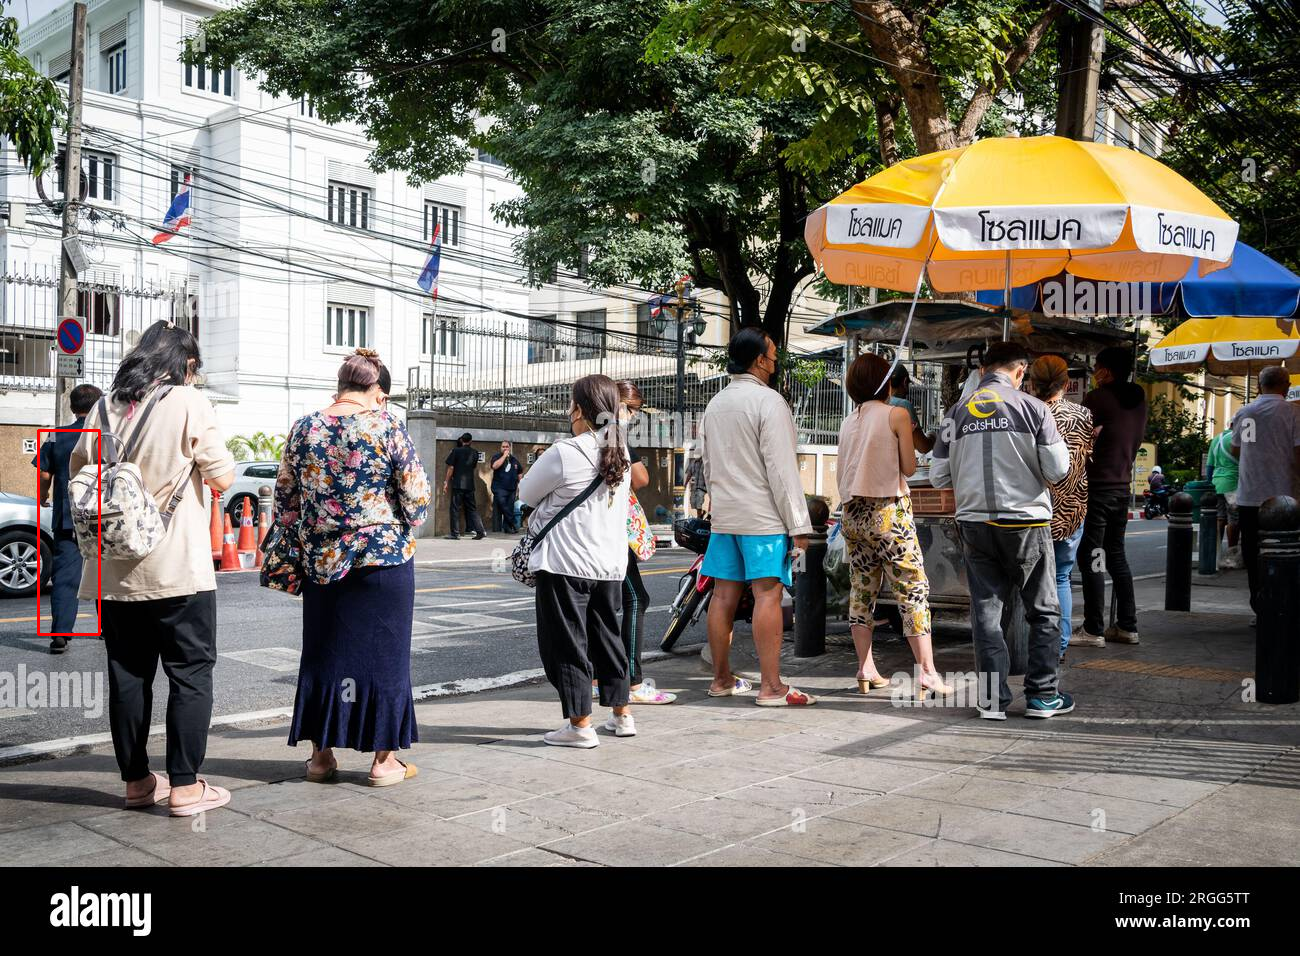

In [8]:
process_image('Q3_pose8.jpg', 'output_image.jpg')